# Task description

## NoSQL data - Spark and PySpark

1. Choose a data source that comes in any text format, and this time, it must not be as strict as the data format for a relational database. E.g. your data might have varying numbers of keys, varying types of values, etc. If you don’t have an own data source, try to save data from an API that gives you large JSON responses such as the Twitter Streaming API.
2. Download a pre-installed version of Spark on your own computer or on a remote computer and install and link PySpark to the Spark executables: https://medium.com/tinghaochen/how-to-install-pyspark-locally-94501eefe421
Demonstrate that you can access your Spark from a Jupyter Notebook by importing pyspark and creating your first SparkContext object. If possible, have a look at the logs in the terminal of the notebook server. Make a screenshot about the jvm engine.
3. Go to the localhost port where you can graphically access the Spark jobs. Try to understand what you have there, make a screenshot.
Read in your textfiles into a SparkContext object, create your first Spark pipeline where you
- - Convert the text row into meaningful variables (e.g. splitting a csv line at commas, then converting the classes of the strings you got to int/float what you need).
-- Filter your rows
-- Calculate at least one aggregated result with the reduceByKey method.
-- Check each step by using the first(n) or take(n) operations that limit the number of rows you fetch from the SparkContext instance!
4. Advanced: experiment with flatMap!
5. Either collect your results into memory with the .collect() method, or write them out as textfiles. 
6. Create a visualization that demonstrates a task that you solved with PySpark.
7. Check parallel processor usage with htop while running your Spark job. Make a screenshot about Spark running on all of your cores!

Document your workflow in a git repository. You should turn in the link of the git repo in the end. Create a README.md in the root of the repo that contains the source and the documentation of the data, and contains your notes about the whole process. Include the screenshots and what you learned from the task.

---

My main computer is a mac, so I set up a working system on Mac OS, which is sort of similiar to a linux distribution, with some differences, that I will pinpoint.

Since on the current system (Big Sur - 2020 December) Python is somewhat bugged, I had to install a separate environment, I chose Miniconda. I tried to use this guide, I had to adjust it in minor ways: https://medium.com/macoclock/how-to-install-apache-pyspark-on-macbook-pro-4a9249f0d823

# Installing main dependencies

1. Miniconda was as easy as downloading an installer, and installing it. https://docs.conda.io/projects/conda/en/latest/user-guide/install/macos.html

2. Java was again, easy, just had to download and install the latest Java Runtime: https://www.java.com/en/download/ (Version 8 Update 271)

3. Installing PySpark. This is where I used conda for the first time:
conda install pyspark

4. Installing FindSpark:
conda install -c conda-forge findspark

5. Installing Jupyter Notebook:
conda install notebook

# Checking things if they work

1. Started Jupyter Notebook typing "jupyter notebook" in the Terminal.

2. Trying if it works:


In [1]:
import findspark
findspark.init()

from pyspark import SparkConf, SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import Row, SQLContext
import random

import sys
import traceback

In [2]:
sc = SparkContext(appName="Pi")
num_samples = 100000000

def inside(p):     
  x, y = random.random(), random.random()
  return x*x + y*y < 1

count = sc.parallelize(range(0, num_samples)).filter(inside).count()

pi = 4 * count / num_samples
print(pi)

3.14159764


![title](test_terminal.png)

After that I could check the following: http://localhost:4040/ where I could see that it correctly performed the operations.

![title](test_jobs.png)

This was a sample task that I found on the internet, it calculates the value of pi using a monte-carlo simulation method. Looking at Spark Jobs page we can see a counting job that was performed, hence "Completed", the running time was 13 seconds, and all the stages (8 stages - 8 lines) was completed successfully.

In [3]:
sc.stop()

---

# Creating a Spark Context for receiving Twitter data

At this point I had to make 2 separate notebooks, one for the Spark setup and handling data, the other for the Twitter Stream API.

I created the pipeline for the datastream, so I can receive tweets, and pipe them into the created Spark Context.

In [2]:
# create spark configuration
conf = SparkConf()
conf.setAppName("TwitterStreamApp")
# create spark context with the above configuration
sc = SparkContext(conf=conf)
sc.setLogLevel("ERROR")
# create the Streaming Context from the above spark context with interval size 2 seconds
ssc = StreamingContext(sc, 2)
# setting a checkpoint to allow RDD recovery
ssc.checkpoint("checkpoint_TwitterApp")
# read data from port 37346
dataStream = ssc.socketTextStream("localhost", 37346)

After setting up the basic datastream comes handling the data and starting the stream.

# Processing incoming stream, storing the result

Here I split the tweets into words and calculated each word's occurence.

In [3]:
def aggregate_hashtags_count(new_values, total_sum):
    return sum(new_values) + (total_sum or 0)

In [4]:
def get_sql_context_instance(spark_context):
    if ('sqlContextSingletonInstance' not in globals()):
        globals()['sqlContextSingletonInstance'] = SQLContext(spark_context)
    return globals()['sqlContextSingletonInstance']

def process_rdd(time, rdd):
    print("----------- %s -----------" % str(time))
    try:
        # Get spark sql singleton context from the current context
        sql_context = get_sql_context_instance(rdd.context)
        # convert the RDD to Row RDD
        row_rdd = rdd.map(lambda w: Row(hashtag=w[0], hashtag_count=w[1]))
        # create a DF from the Row RDD
        hashtags_df = sql_context.createDataFrame(row_rdd)
        # Register the dataframe as table
        hashtags_df.registerTempTable("hashtags")
        # get the top 10 hashtags from the table using SQL and print them
        hashtag_counts_df = sql_context.sql("select hashtag , hashtag_count from hashtags order by hashtag_count desc limit 10")
        hashtag_counts_df.show()
        hashtag_counts_df.coalesce(1).write.format('com.databricks.spark.csv').mode('overwrite').option("header", "true").csv("/Users/petertakacs/Downloads/hashtag_file.csv") 
    except:
        traceback.print_exception(*sys.exc_info())

In [5]:
# split each tweet into words
hashtags = dataStream.flatMap(lambda line: line.split(" "))
# filter the words to get only hashtags, then map each hashtag to be a pair of (hashtag,1)
hashtags = hashtags.filter(lambda w: '#' in w).map(lambda x: (x, 1))
# adding the count of each hashtag to its last count
hashtags_totals = hashtags.updateStateByKey(aggregate_hashtags_count)
# do processing for each RDD generated in each interval
hashtags_totals.foreachRDD(process_rdd)
# start the streaming computation
ssc.start()
# wait for the streaming to finish
ssc.awaitTermination()

----------- 2021-01-28 21:12:46 -----------


Traceback (most recent call last):
  File "<ipython-input-4-a527eb6f0b8c>", line 14, in process_rdd
    hashtags_df = sql_context.createDataFrame(row_rdd)
  File "/usr/local/opt/apache-spark/libexec/python/pyspark/sql/context.py", line 320, in createDataFrame
    return self.sparkSession.createDataFrame(data, schema, samplingRatio, verifySchema)
  File "/usr/local/opt/apache-spark/libexec/python/pyspark/sql/session.py", line 605, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/usr/local/opt/apache-spark/libexec/python/pyspark/sql/session.py", line 628, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/usr/local/opt/apache-spark/libexec/python/pyspark/sql/session.py", line 425, in _createFromRDD
    struct = self._inferSchema(rdd, samplingRatio, names=schema)
  File "/usr/local/opt/apache-spark/libexec/python/pyspark/sql/session.py", line 396, in _inferSchema
    first = 

----------- 2021-01-28 21:12:48 -----------


Traceback (most recent call last):
  File "<ipython-input-4-a527eb6f0b8c>", line 14, in process_rdd
    hashtags_df = sql_context.createDataFrame(row_rdd)
  File "/usr/local/opt/apache-spark/libexec/python/pyspark/sql/context.py", line 320, in createDataFrame
    return self.sparkSession.createDataFrame(data, schema, samplingRatio, verifySchema)
  File "/usr/local/opt/apache-spark/libexec/python/pyspark/sql/session.py", line 605, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/usr/local/opt/apache-spark/libexec/python/pyspark/sql/session.py", line 628, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/usr/local/opt/apache-spark/libexec/python/pyspark/sql/session.py", line 425, in _createFromRDD
    struct = self._inferSchema(rdd, samplingRatio, names=schema)
  File "/usr/local/opt/apache-spark/libexec/python/pyspark/sql/session.py", line 396, in _inferSchema
    first = 

----------- 2021-01-28 21:12:50 -----------
+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|#FridayLivestream|            1|
+-----------------+-------------+

----------- 2021-01-28 21:12:52 -----------
+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|             #gay|            1|
|#FridayLivestream|            1|
|        #exposure|            1|
|            #Both|            1|
|    #BellLetsTalk|            1|
+-----------------+-------------+

----------- 2021-01-28 21:12:54 -----------
+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|             #gay|            1|
|         #Sherman|            1|
|         #foxnews|            1|
|      #ZikokoQuiz|            1|
|#FridayLivestream|            1|
|        #exposure|            1|
|            #Both|            1|
|    #BellLetsTalk|            1|
|             #N

----------- 2021-01-28 21:13:26 -----------
+----------------+-------------+
|         hashtag|hashtag_count|
+----------------+-------------+
|   #BellLetsTalk|            4|
|    #HoldTheLine|            2|
|            #gay|            1|
|        #Sherman|            1|
|   #Dogecoinarmy|            1|
|          #Unity|            1|
|#blackexcellence|            1|
|          #mgarr|            1|
|        #foxnews|            1|
|     #ZikokoQuiz|            1|
+----------------+-------------+

----------- 2021-01-28 21:13:28 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #BellLetsTalk|            4|
|#SilhoutteChallenge|            2|
|       #HoldTheLine|            2|
|               #gay|            1|
|           #Sherman|            1|
|      #Dogecoinarmy|            1|
|             #Unity|            1|
|   #blackexcellence|            1|
|             #mgarr|            1|
|           #foxn

----------- 2021-01-28 21:13:56 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #BellLetsTalk|            5|
|#SilhoutteChallenge|            2|
|         #Education|            2|
| #dogecointo1dollar|            2|
|               #art|            2|
|               #tbt|            2|
|       #HoldTheLine|            2|
|               #gay|            1|
|           #Sherman|            1|
|      #Dogecoinarmy|            1|
+-------------------+-------------+

----------- 2021-01-28 21:13:58 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #BellLetsTalk|            5|
|#SilhoutteChallenge|            2|
|         #Education|            2|
|            #TOTLIV|            2|
| #dogecointo1dollar|            2|
|               #art|            2|
|               #tbt|            2|
|       #HoldTheLine|            2|
|          

----------- 2021-01-28 21:14:26 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #BellLetsTalk|            9|
|               #tbt|            2|
|         #Education|            2|
|#SilhoutteChallenge|            2|
|            #TOTLIV|            2|
|             #Sales|            2|
|                #IT|            2|
|            #pdx911|            2|
| #dogecointo1dollar|            2|
|               #art|            2|
+-------------------+-------------+

----------- 2021-01-28 21:14:28 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #BellLetsTalk|            9|
|               #tbt|            2|
|         #Education|            2|
|#SilhoutteChallenge|            2|
|            #TOTLIV|            2|
|             #Sales|            2|
|                #IT|            2|
|            #pdx911|            2|
| #dogecoin

----------- 2021-01-28 21:14:56 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #BellLetsTalk|           10|
|             #Sales|            3|
|      #SkilledTrade|            2|
|               #art|            2|
|#SilhoutteChallenge|            2|
|         #Education|            2|
|            #TOTLIV|            2|
|                #IT|            2|
|            #pdx911|            2|
| #dogecointo1dollar|            2|
+-------------------+-------------+

----------- 2021-01-28 21:14:58 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #BellLetsTalk|           10|
|             #Sales|            3|
|          #dogecoin|            3|
|      #SkilledTrade|            2|
|               #art|            2|
|#SilhoutteChallenge|            2|
|         #Education|            2|
|            #TOTLIV|            2|
|          

----------- 2021-01-28 21:15:26 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #BellLetsTalk|           12|
|            #TOTLIV|            3|
|             #Sales|            3|
|          #dogecoin|            3|
|             #4Line|            2|
|      #SkilledTrade|            2|
|            #stocks|            2|
|           #massage|            2|
|             #2Line|            2|
|#SilhoutteChallenge|            2|
+-------------------+-------------+

----------- 2021-01-28 21:15:28 -----------
+-------------+-------------+
|      hashtag|hashtag_count|
+-------------+-------------+
|#BellLetsTalk|           12|
|       #Sales|            4|
|#SkilledTrade|            3|
|      #TOTLIV|            3|
|    #dogecoin|            3|
|     #Nursing|            2|
|       #4Line|            2|
|   #Hempstead|            2|
| #SupplyChain|            2|
|      #stocks|            2|
+-------------+--

----------- 2021-01-28 21:15:58 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #BellLetsTalk|           14|
|             #Sales|            4|
| #dogecointo1dollar|            4|
|          #dogecoin|            4|
|#SilhoutteChallenge|            3|
|      #SkilledTrade|            3|
|            #stocks|            3|
|            #TOTLIV|            3|
|                #IT|            3|
|           #Nursing|            2|
+-------------------+-------------+

----------- 2021-01-28 21:16:00 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #BellLetsTalk|           14|
|             #Sales|            4|
| #dogecointo1dollar|            4|
|          #dogecoin|            4|
|#SilhoutteChallenge|            3|
|      #SkilledTrade|            3|
|            #stocks|            3|
|            #TOTLIV|            3|
|          

----------- 2021-01-28 21:16:28 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #BellLetsTalk|           16|
|          #dogecoin|            5|
|             #Sales|            4|
|            #pdx911|            4|
| #dogecointo1dollar|            4|
|              #DOGE|            3|
|#SilhoutteChallenge|            3|
|      #SkilledTrade|            3|
|            #stocks|            3|
|            #TOTLIV|            3|
+-------------------+-------------+

----------- 2021-01-28 21:16:30 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #BellLetsTalk|           16|
|          #dogecoin|            5|
|             #Sales|            4|
|            #pdx911|            4|
| #dogecointo1dollar|            4|
|              #DOGE|            3|
|#SilhoutteChallenge|            3|
|      #SkilledTrade|            3|
|          

KeyboardInterrupt: 

As we can see it works as intended. It prints out top 10 of the hashtags, and it adds the collected and processed stream to its database every 2 second.

# Visualization

In the following I will visualize the top 10 hashtags in a histogram.

In [1]:
import pandas as pd

data = pd.read_csv('/Users/petertakacs/Downloads/hashtag_file.csv/part-00000-206705bf-4947-49de-b571-041181098d2a-c000.csv')

data

,hashtag,hashtag_count
0,#BellLetsTalk,20
1,#dogecoin,6
2,#Sales,5
3,#SilhoutteChallenge,5
4,#pdx911,4
5,#dogecointo1dollar,4
6,#Nursing,3
7,#stocks,3
8,#4Line,3
9,#SkilledTrade,3


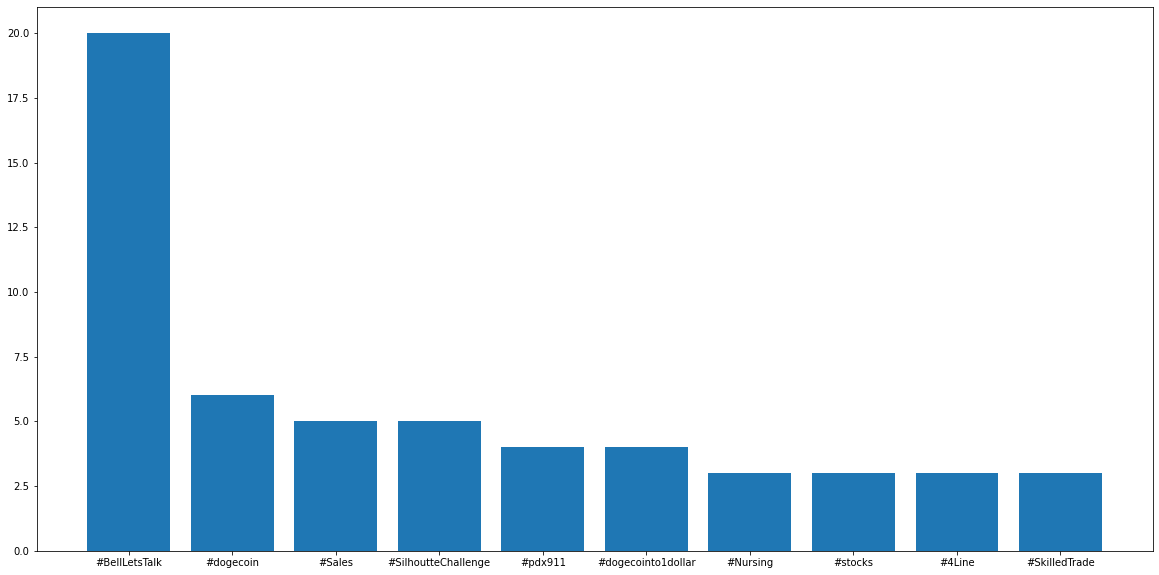

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.bar(data["hashtag"], data["hashtag_count"])
plt.show()

# Processor usage

![title](htop.png)

# References
1. https://medium.com/macoclock/how-to-install-apache-pyspark-on-macbook-pro-4a9249f0d823
2. https://requests-oauthlib.readthedocs.io/en/latest/oauth1_workflow.html
3. https://www.toptal.com/apache/apache-spark-streaming-twitter